In [2]:
from VAE.VAEmodel import *
from vectorized_SC_FC.corticalSCFCDatasetVect import * 
from vectorized_SC_FC.diffusionModelVec import * 
from vectorized_SC_FC.model_eval import * 
from vectorized_SC_FC.networkModelDit import *  
from vectorized_SC_FC.networkModelVect import *
from vectorized_SC_FC.SCFC_data_extraction import *
from vectorized_SC_FC.utilsVect import *
from vectorized_SC_FC.UnetCrossAttention import *
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from encodedFCDataset import *
from networkModelLatent  import *

SEED = 2
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 128

## Load the data and split it

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

_, cortical_FC, cortical_SC = load_cortical_SC_FC(FC_path = 'vectorized_SC_FC/data/desikan_fc_all.mat',
                                                  SC_path = 'vectorized_SC_FC/data/HCP_cortical_DesikanAtlas.mat',
                                                  transform_SC = True, transform_FC = False)

FC_train, FC_val, SC_train, SC_val = train_test_split(cortical_FC, cortical_SC, test_size=0.2, random_state=42)

loader = DataLoader(corticalSCFCDataset(SC_matrices= SC_train, FC_matrices= FC_train, vectorize=True), batch_size, shuffle=True)
loader_val = DataLoader(corticalSCFCDataset(SC_matrices= SC_val, FC_matrices= FC_val, vectorize=True), batch_size, shuffle=True)

Using device: cuda	NVIDIA RTX A6000


## Load pretrained VAE and encode data into the latent space

In [8]:
input_dim_vae = 2278  # Example for 5x5 correlation matrices
hidden_dim_vae = 1139
latent_dim_vae = 512

best_AE = AutoEncoder(input_dim_vae, latent_dim_vae, hidden_dim_vae, device = device).to(device)
best_AE.load_state_dict(torch.load("VAE/models/AutoEncoder.pt", map_location=device))
best_AE.eval()
print("Model loaded")

with torch.no_grad():
    FC_vec, SC_vec = loader.dataset[:]
    encoded_fc = best_AE.encoder(FC_vec.to(device))
for parameter in best_AE.parameters():
    parameter.requires_grad_(False)

Model loaded


## Train diffusion model on latent space

In [30]:
### Architecture length

attn = True
num_heads = 64


#Diffusion parameters
min_beta = 10 ** - 4
max_beta = 0.02
n_steps = 1000

#Training parameters
n_epochs = 50
lr = 0.0005
store_path = "Latent_test1_unet.pt"


#loader = DataLoader(corticalSCFCDataset(SC_matrices= cortical_SC, FC_matrices= cortical_FC, vectorize=True), batch_size, shuffle=True)

#DiT = DiTNN(channels_in = 1, L = 2278, patch_size= patch_size, emb_dim=emb_dim, num_heads = num_heads, ff_dim = ff_dim, n_steps = n_steps, time_emb_dim = time_emb_dim, num_blocks=num_blocks)
#Unet = MyUNet(n_steps, dim_space = latent_dim)
#DitAdaLN = DiTNNadaLN(channels_in = 1, L = latent_dim_vae, patch_size = patch_size, emb_dim = emb_dim, num_heads=num_heads, mlp_ratio = mlp_ratio,
#                        n_steps = n_steps, time_emb_dim = emb_dim, num_blocks=num_blocks)
Network = CondUNet(n_steps=n_steps, time_emb_dim=100, attn=True, n_heads=32)

ddpm = MyDDPM(Network, n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device, vect_cl=(1,latent_dim_vae))
optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
latent_loader = DataLoader(encodedFCDataset(FC_encoded=encoded_fc, SC_vectors = SC_vec), batch_size = 64, shuffle = True)

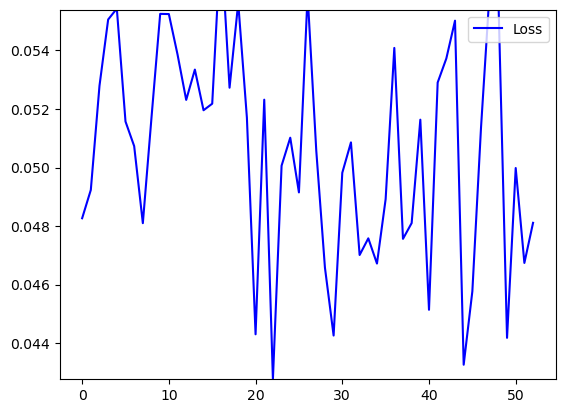

Best loss at epoch 23 with loss 0.0428


Epoch 54/100:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

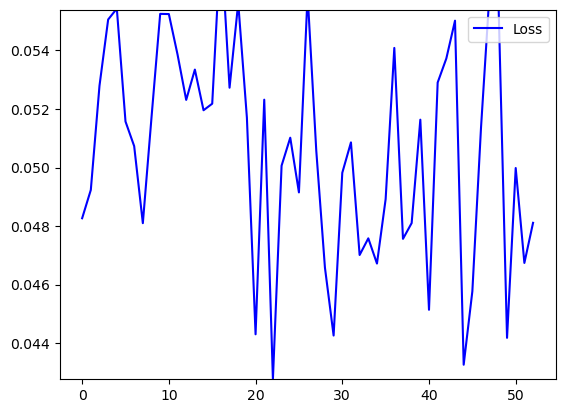

In [33]:
optim = torch.optim.Adam(ddpm.parameters(), lr=1e-6)
training_loop(ddpm, latent_loader, 100, optim, device, store_path=store_path)

In [35]:
def vectorize_uppdiag_matrix(X):
    X = torch.tensor(X).to(torch.float32)
    rows, cols = torch.triu_indices(X.size(1), X.size(2), offset=1)
    X_vect = X[:, rows, cols]
    return X_vect.reshape(X_vect.size(0), 1, X_vect.size(1))

def generate_corr_matrix(vector, n=68):
    matrices = torch.zeros((vector.shape[0], n, n))
    row_idx, col_idx = torch.triu_indices(n, n, offset=1)
    for i in range(vector.shape[0]):
        matrices[i][row_idx, col_idx] = vector[i]
        matrices[i][col_idx, row_idx] = vector[i]
        matrices[i].fill_diagonal_(1)
    return matrices

best_Network = CondUNet(n_steps=n_steps, time_emb_dim=100, attn=True, n_heads=64)
#store_path = "LDM_SC_FC_decent1Head32.pt
store_path="Latent_test1_unet.pt"
best_model = MyDDPM(best_Network, n_steps=n_steps, device=device, vect_cl=(1, latent_dim_vae), min_beta = min_beta, max_beta = max_beta)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [36]:
n_samples = 6
#indeces = np.random.choice(list(range(1058)), n_samples)
indeces = [1,1,3,3,10,10]

conditions = vectorize_uppdiag_matrix(SC_val[indeces])

z_hat = best_model.sample(condition = conditions, n_samples = n_samples)
with torch.no_grad():
    vect_hat = best_AE.decoder(z_hat).cpu()

FC_hat = generate_corr_matrix(vect_hat)
FC_real = torch.tensor(FC_val[indeces]).cpu()
plot_correlation_matrices(FC_real, FC_hat, FC_real - FC_hat)


In [ ]:
def sample(self, condition, n_samples = 16):
    """We will sample a matrix from a condition matrix"""

    with torch.no_grad():
        #We start from random noise
        x = torch.randn(n_samples, self.c, self.l).to(self.device)
        condition = condition.to(self.device)

        for idx, t in enumerate(list(range(self.n_steps))[::-1]):
            time_tensor = (torch.ones(n_samples, 1) * t).to(self.device).long()
            eta_theta = self.backward(x, time_tensor, condition)

            alpha_t = self.alphas[t]
            alpha_t_bar = self.alpha_bars[t]

            x = (1 / alpha_t.sqrt()) * ((x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt()) * eta_theta)
            if t > 0:
                z = torch.randn(n_samples, self.c, self.l).to(self.device)

                # Option 1: sigma_t squared = beta_t
                beta_t = self.betas[t]
                # sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                prev_alpha_t_bar = self.alpha_bars[t-1] if t > 0 else self.alphas[0]
                beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + 0 * z
        #we transform to -1 to 1
        return x.reshape(n_samples, self.l)

In [28]:
sample(ddpm, condition = conditions, n_samples = n_samples)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')